In [204]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

from AugmentationFinal import Ada, GaussianBlur, AddNoise, OverlayBox, RandomBox, RandomShift, RandomRotate, RandomZoom, RandomMirror, RandomHorizontalFlip, custom_data_augmentation_func
from DataPrep import get_df_train, data_generator, get_train_val, load_data
from utils import display_imgs
from Metrics import dice_coef, dice_loss
from Callbacks import DisplayCallback

In [205]:
from absl import logging
import warnings
from tqdm import tqdm

In [206]:
def make_dummy_model(img_size):

    if len(img_size) == 2:
        shape = (img_size[0], img_size[1], 3)
    if len(img_size) == 3:
        shape = img_size
    
    inputs = tf.keras.Input(shape=shape)
    x = layers.Conv2D(32, kernel_size=3, strides=1, padding="same", name='Conv1')(inputs)
    x = layers.BatchNormalization(name='BN')(x)
    x = layers.Activation("relu", name='Act')(x)
    outputs = layers.Conv2D(filters=1, kernel_size=3, activation="sigmoid", padding="same", name='Conv2')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [207]:
class DoNothing(tf.keras.Model):

    def __init__(self, **kwargs):

        super(DoNothing, self).__init__(**kwargs)
        self.probability = tf.Variable(0.0, trainable=False)

    def update(self, loss):
        self.probability.assign(loss)

    def call(self, inputs, training=False):
        return inputs

class MyModel(tf.keras.Model):

    def __init__(self, 
                 img_size,
                 augment_func, # ada_p=0.5, ada_batch_p=0.0,
                 **kwargs):
               
        super(MyModel, self).__init__(**kwargs)

        self.img_size = img_size
        self.train_step_counter = tf.Variable(0, dtype=tf.int32, trainable=False)
        self.model = make_dummy_model(img_size)
        self.ada = augment_func
 
    def compile(self, optimizer=None, metrics=[], *args, **kwargs):

        assert isinstance(metrics, list), "metrics input must be a list"
        self.train_step_counter.assign(0)
        self.optimizer = optimizer
        self.loss_tracker = metrics[0] if len(metrics) == 1 else tf.keras.metrics.Mean(name="loss_metric") ###### Make it so metrics can be multiple items ######
        self.dice_coeff_tracker = tf.keras.metrics.Mean(name="dice_coeff_metric")     
        self.augmentation_probability_tracker = tf.keras.metrics.Mean(name="aug_probability")

        super(MyModel, self).compile(*args, **kwargs)

    @property
    def metrics(self):

        return [self.loss_tracker, self.dice_coeff_tracker, self.augmentation_probability_tracker]
    
    def train_step(self, ds_input): # If you pass a tf.data.Dataset, by calling fit(dataset, ...), then data will be what gets yielded by dataset at each batch.

        self.train_step_counter.assign_add(1)
        augmented_images, augmented_masks = self.ada(ds_input, training=True) # out: tf.float32, tf.int32 <- in: tf.float32, tf.int32
        
        with tf.GradientTape() as tape: # WARNING:tensorflow:The dtype of the target tensor must be floating (e.g. tf.float32) when calling GradientTape.gradient, got tf.int32

            predicted = self.model(augmented_images, training=True) # out: tf.float32 <- in: tf.float32
            loss = self.compiled_loss(augmented_masks, predicted) # out: tf.float32 <- in: tf.float32, tf.float32 IF loss is tf.int32 THIS WILL GIVE ERROR OF: No gradients provided for any variable, LOSS FUNCTION NEED TO RETURN FLOAT32, I THINK
            
        trainable_weights = self.model.trainable_variables # self.model.trainable_weights
        model_grads = tape.gradient(loss, trainable_weights)
        self.optimizer.apply_gradients(zip(model_grads, trainable_weights))
        
        self.ada.update(loss)
        self.loss_tracker.update_state(loss)
        self.dice_coeff_tracker.update_state(1-loss)     
        self.augmentation_probability_tracker.update_state(self.ada.probability)
        
        return {m.name: m.result() for m in self.metrics}

    def call(self, inputs, training=False, augment=False):

        augmented_images, augmented_masks = self.ada(inputs, training=training) if augment else inputs
        predicted = self.model(augmented_images, training=training)
        return augmented_images, augmented_masks, predicted

# Make Training Possible with all Combinations

In [208]:
# TODO:
    # ADD ARGUMENT THAT SPECIFIES IF WE WANT DATA AUGMENTATION
    # Make it so that callbacks work in eagerly
    # Do something about FixedMean()

In [209]:
def get_data(args):

    if args.augment_in_ds == True: 
        ds_augment_func = custom_data_augmentation_func()

    if args.augment_in_ds == False: 
        ds_augment_func = None

    df_train, df_train_mask = get_df_train(args)
    df_train, df_val = get_train_val(df_train, aug=True)

    ds_train = data_generator(image_list=df_train['path'].to_list(), mask_list=df_train['mask_path'].to_list(), split='train', img_size=args.img_size, ds_augment_func=ds_augment_func, batch_size=args.batch_size)
    ds_val = data_generator(image_list=df_val['path'].to_list(), mask_list=df_val['mask_path'].to_list(), split='val', img_size=args.img_size, ds_augment_func=ds_augment_func, batch_size=args.batch_size)
    
    return ds_train, ds_val

In [259]:
def setup_model(args):

    augment_func = DoNothing() if args.augment_in_ds else Ada()
    # augment_func = Ada(p=0.0) if args.augment_in_ds else Ada(p=0.5)

    if args.training_method == 'train_step': 
        
        my_model = MyModel(img_size=args.img_size, augment_func=augment_func)
        return None, my_model

    else:

        my_model = make_dummy_model(img_size=args.img_size)
        if args.training_method == 'fit' and args.augment_in_ds == False: ##### ADD ARGUMENT THAT SPECIFIES IF WE WANT DATA AUGMENTATION #####
            warnings.warn('Cannot have args.augment set to True, args.augment_in_ds set to False with args.training_method set to fit, will not perform data augmentation')

        return augment_func, my_model

In [211]:
def set_up_to_train(args):

    # Keep track of metrics with Mean
    augmentation_probability_tracker = tf.keras.metrics.Mean(name="aug_probability")
    dice_coeff_tracker = tf.keras.metrics.Mean(name="dice_coeff_metric")
    val_dice_coeff_tracker = tf.keras.metrics.Mean(name="val_dice_coeff_metric")

    # Get optimizer
    optimizer = tf.keras.optimizers.get(args.optimizer)
    config_opt = {"learning_rate": 1e-3, "beta_1": 0.15, "beta_2": 0.99, "epsilon": 1e-8}
    optimizer = optimizer.from_config(config=config_opt)

    # Get loss tracker
    loss_tracker = tf.keras.metrics.get(args.metrics)
    config_metrics = {'name': "loss_metric"}
    loss_tracker = loss_tracker.from_config(config=config_metrics)

    # Get val loss tracker
    val_loss_tracker = tf.keras.metrics.get(args.val_metrics)
    config_metrics = {'name': "loss_metric"}
    val_loss_tracker = val_loss_tracker.from_config(config=config_metrics)

    return optimizer, augmentation_probability_tracker, dice_coeff_tracker, loss_tracker, val_dice_coeff_tracker, val_loss_tracker

In [272]:
class args:
    base_path = r'D:\DL-CV-ML Projects\Carvana Challenge - Instance Segmentation'
    img_size = (128, 128)
    batch_size = 86
    epochs = 3
    augment_in_ds = False # arg.add_argument("-a", "--augment", type=bool, default=False, help="Whether to augment within the dataset or use a model before the main model")
    training_method = 'eagerly' # arg.add_argument("-tm", "--training_method", choices=["fit", "eagerly", "train_step"], help="Method to use to train the model")
    optimizer = 'Adam' # arg.add_argument("-o", "--optimizer")
    metrics = 'Mean' # arg.add_argument("-m", "--metrics", nargs="+")
    val_metrics = 'Mean' # arg.add_argument("-vm", "--val_metrics", nargs="+)

In [214]:
ds_train, ds_val = get_data(args)

In [215]:
test_imgs = next(iter(ds_train))

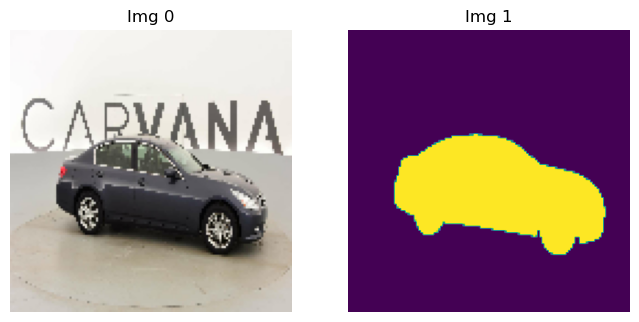

In [217]:
display_imgs(*test_imgs)

In [218]:
test_augmenter = custom_data_augmentation_func(p=0.5)

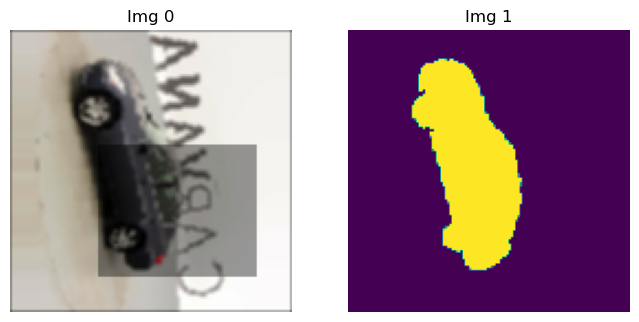

In [250]:
display_imgs(*test_augmenter(test_imgs))

In [223]:
EarlyStop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss_metric', patience=5, mode='min', restore_best_weights=True)
callbacks_list = [EarlyStop_callback, DisplayCallback(img_path=r'D:\DL-CV-ML Projects\Carvana Challenge - Instance Segmentation\29bb3ece3180_11.jpg', args=args)]

In [224]:
augment_func, temp_model = setup_model(args)

In [227]:
optimizer, augmentation_probability_tracker, dice_coeff_tracker, loss_tracker, val_dice_coeff_tracker, val_loss_tracker = set_up_to_train(args)

In [228]:
class FixedMean(tf.keras.metrics.Mean):
    def update_state(self, y_true, y_pred, sample_weight=None):
        super().update_state(y_pred, sample_weight=sample_weight)

In [ ]:
@tf.function
def train_step(imgs, labels):

    imgs, labels = augment_func((imgs, labels), training=True)

    with tf.GradientTape() as tape:
        predicted = temp_model(imgs, training=True)
        loss_value = dice_loss(labels, predicted)
        
    grads = tape.gradient(loss_value, temp_model.trainable_weights)
    optimizer.apply_gradients(zip(grads, temp_model.trainable_weights))

    augment_func.update(loss_value)
    loss_tracker.update_state(loss_value)
    dice_coeff_tracker.update_state(1-loss_value)
    augmentation_probability_tracker.update_state(augment_func.probability)
    return loss_value

@tf.function
def test_step(imgs, labels):

    val_predicted = temp_model(imgs, training=False)
    loss_value = dice_loss(labels, val_predicted)

    val_loss_tracker.update_state(loss_value)
    val_dice_coeff_tracker.update_state(1-loss_value)

Epoch: 1: 100%|██████████| 32/32 [00:24<00:00,  1.32 Batches/s, augmentation_probability=0, dice_coefficient=0.0399, loss=0.96] 


Validation: Epoch - 1 val_acc - 0.048054274171590805 - val_loss - 0.9519455432891846


  0%|          | 0/32 [00:00<?, ? Batches/s]

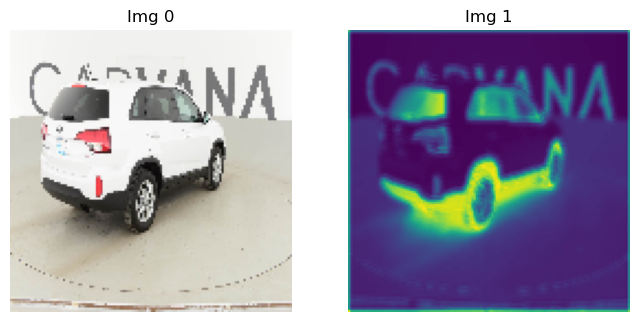

Epoch: 2: 100%|██████████| 32/32 [00:18<00:00,  1.78 Batches/s, augmentation_probability=0, dice_coefficient=0.0638, loss=0.936]


Validation: Epoch - 2 val_acc - 0.06562299281358719 - val_loss - 0.9343770146369934


Epoch: 3: 100%|██████████| 32/32 [00:18<00:00,  1.78 Batches/s, augmentation_probability=0, dice_coefficient=0.074, loss=0.926] 


Validation: Epoch - 3 val_acc - 0.07244820147752762 - val_loss - 0.9275518655776978


In [229]:
if args.training_method == 'eagerly':

    img_path=r'D:\DL-CV-ML Projects\Carvana Challenge - Instance Segmentation\29bb3ece3180_11.jpg'
    test_img_for_epoch_viz = img_to_array(load_img(img_path, target_size=args.img_size)) / 255

    for epoch in range(1, args.epochs + 1):

        with tqdm(enumerate(ds_train), unit=' Batches', total=len(ds_train)) as tepoch:

            # Callback
            if (epoch + 1) % 3 == 0 or epoch == 1:
                test_pred_mask = temp_model(test_img_for_epoch_viz[None, ...], training=False)
                display_imgs(test_img_for_epoch_viz, test_pred_mask[0])

            # for batch, (images, labels) in enumerate(ds_train):
            for batch, (images, labels) in tepoch:

                # Set description and get loss value
                tepoch.set_description(f"Epoch: {epoch}")
                loss_value = train_step(images, labels)        

                # Display results after each batch
                train_loss = loss_tracker.result()
                train_acc = dice_coeff_tracker.result()
                aug_p = augmentation_probability_tracker.result()
                tepoch.set_postfix(loss=train_loss.numpy(), dice_coefficient=train_acc.numpy(), augmentation_probability=aug_p.numpy())

        # Reset metrics at the end of each epoch
        dice_coeff_tracker.reset_states()
        loss_tracker.reset_states()
        
        for batch, (images, labels) in enumerate(ds_val):

            test_step(images, labels)

        # Display results after each epoch
        val_acc = val_dice_coeff_tracker.result()
        val_loss = val_loss_tracker.result()
        print("Validation: Epoch - {} val_acc - {} - val_loss - {}".format(epoch, val_acc, val_loss))
        
        # Reset metrics at the end of each epoch
        val_dice_coeff_tracker.reset_states()
        val_loss_tracker.reset_states()
else:

    temp_model.compile(optimizer=optimizer, loss=dice_loss, metrics=[loss_tracker]) # FixedMean()
    temp_model.fit(ds_train, epochs=args.epochs, callbacks=callbacks_list)

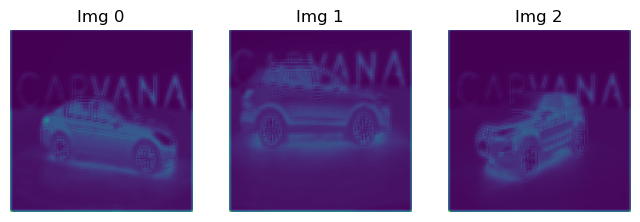

In [236]:
display_imgs(*temp_model(test_imgs[0], training=False)[0:3]) # test_imgs, test_imgs[0] | augment=False

In [273]:
import time

In [292]:
tf.cond(tf.less(tf.random.uniform([]), 0.), lambda: time.sleep(1), lambda: (1, 1))

(1, 1)

# TFRecords

In [15]:
from utils import save_images_to_tfrecord, read_tfrecord

In [16]:
output_file = r"D:\DL-CV-ML Projects\Carvana Challenge - Instance Segmentation\TFRecordFiles\train.tfrecord"
train_path = r'D:\DL-CV-ML Projects\Carvana Challenge - Instance Segmentation\train\train'
mask_path = r'D:\DL-CV-ML Projects\Carvana Challenge - Instance Segmentation\train_masks\train_masks'
# save_images_to_tfrecord(train_path, mask_path, output_file)

In [251]:
tfrecord_file = 'D:\\DL-CV-ML Projects\\Carvana Challenge - Instance Segmentation\\TFRecordFiles\\train.tfrecord'
features = read_tfrecord(tfrecord_file)

In [252]:
features

{'image/encoded': FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
 'image/width': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'image/height': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'image/filename': FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
 'mask/encoded': FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
 'mask/width': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'mask/height': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'mask/filename': FixedLenFeature(shape=[], dtype=tf.string, default_value=None)}

# Extra

In [ ]:
       # if args.augment_in_ds == True:
        #     self.ada = DoNothing()
        # else:
        #     self.ada = Ada(p=ada_p, batch_p=ada_batch_p)


        # if augment: augmented_images, augmented_masks = self.ada(inputs, training=training)
        # else: augmented_images, augmented_masks = inputs


# Inputs: imgs: tf.float32 [0, 1], masks: tf.int32 [0, 255]
# Augmentation: input: tf.float32 [0, 1], tf.int32 [0, 255]; output: tf.float32 [0, 1], tf.int32 [0, 255]
# Model: input: tf.float32 [0, 1]; output: tf.float32 [0, 1] <--------- output should be tf.int32 [0, 255] but its ok
# Loss: input: y_true: tf.int32 [0, 255], y_pred: tf.float32 [0, 1]

In [ ]:
    #   if optimizer is None:
    #         self.optimizer = tf.keras.optimizers.Adam(**{"learning_rate": 1e-3, "beta_1": 0.5, "beta_2": 0.99, "epsilon": 1e-8})
    #     elif isinstance(optimizer, str):
    #         self.optimizer = tf.keras.optimizers.get(optimizer)
    #     else: self.optimizer = optimizer

    #     if metrics == []:
    #         self.loss_tracker = tf.keras.metrics.Mean(name="loss_metric")  
    #     elif isinstance(metrics, str):
    #         self.loss_tracker = tf.keras.metrics.get(metrics) 
    #     else: self.loss_tracker = metrics     

In [ ]:
            # if len(img_size) == 2:
            #     img_shape = img_size + (3,)
            #     mask_shape = img_size + (1,)
            
            # if len(img_size) == 3:
            #     img_shape = img_size
            #     mask_shape = (img_size[0], img_size[1], 1)

            # input_img = layers.Input(shape=img_shape)
            # input_mask = layers.Input(shape=mask_shape)
            # x = (input_img, input_mask)
            # x = augment_func(x)
            # x = my_model(x)
            # model_with_augmentation = tf.keras.Model([input_img, input_mask], x, name='model_with_augmentation')
            
            # return None, model_with_augmentation